# Movie Recommendation - SVD Algorithm


This notebook aims to build a movie recommendation mechanism using SVD algorithm on Netflix Prize Dataset. <br>
We faced the challenge of loading data for analysis in the kernel due to memory constraints, so counter that we have used only the first part of combined dataset instead of whole for this algorithm

# Preprocessing

In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics import precision_recall_fscore_support
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

In [2]:
# Reading dataset
df = pd.read_csv('../input/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)
df.index = np.arange(0,len(df))
print('Dataset shape: {}'.format(df.shape))
df.head()

Dataset shape: (24058263, 2)


,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


Text(0.5, 1.0, 'Frequency per Rating')

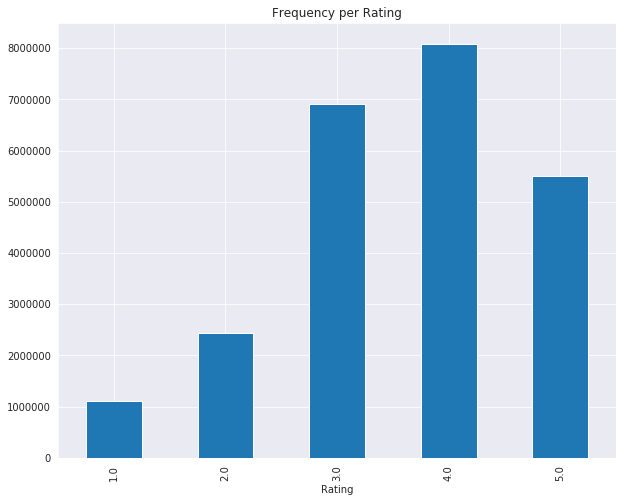

In [3]:
# Plotting user count for each rating
movie_count = df.isnull().sum()[1]
cust_count = df['Cust_Id'].nunique() - movie_count
rating_count = df['Cust_Id'].count() - movie_count

p = df.groupby('Rating')['Rating'].agg(['count'])
p.plot(kind='bar', legend=False, figsize= (10, 8))
plt.title('Frequency per Rating')

**Biased Rating** due to negative rating users will leave platform instead of rating movies.

In [4]:
# Cleaning data, removing Movie_ID rows from the dataset
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
movie_np = []
movie_id = 1
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

print('Dataset Shape: ', df.shape)
df.head()

Dataset Shape:  (24053764, 3)


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [5]:
# Data Slicing - Keeping the relevant data
# Removing movies with too less reviews
# Removing users with too less reviews given

f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

print('Before: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After: {}'.format(df.shape))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0
Before: (24053764, 3)
After: (17337458, 3)


In [6]:
# Create a pivot table from the dataframe
# This is use Customer IDs as index
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(143458, 1350)


In [7]:
# Loading Movie Titles
df_title = pd.read_csv('../input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Recommendation Model - SVD 

In [8]:
# Loading SVD Model
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.9950613 , 1.00633625, 0.99510933, 0.99266488, 0.99507842]),
 'test_mae': array([0.79648892, 0.80764487, 0.79609577, 0.79648425, 0.78405816]),
 'fit_time': (6.201391696929932,
  6.302778005599976,
  6.32655668258667,
  6.275544881820679,
  6.274237394332886),
 'test_time': (0.1631169319152832,
  0.16474628448486328,
  0.15772223472595215,
  0.25695013999938965,
  0.16516757011413574)}

In [9]:
df

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056841,520675,3.0,4496
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056845,1559566,3.0,4496


In [10]:
# Below is what movies user 1331154 liked in the past
df_user = df[(df['Cust_Id'] == 1331154) & (df['Rating'] == 5)]
df_user = df_user.set_index('Movie_Id')
df_user = df_user.join(df_title)['Name']
print("Movies liked user in the Past \n", df_user)

Movies liked user in the Past 
 Movie_Id
143                                          The Game
270                        Sex and the City: Season 4
361         The Phantom of the Opera: Special Edition
457                                 Kill Bill: Vol. 2
482                                             Frida
658                     Robin Hood: Prince of Thieves
763                            The Poseidon Adventure
1144                             Fried Green Tomatoes
1425                                       No Way Out
1476                         Six Feet Under: Season 4
1495                                  Alias: Season 1
1642                 Casino: 10th Anniversary Edition
1650                                     Nine to Five
1754                                  Sixteen Candles
1974                                       Il Postino
2128                                             Rudy
2192                                    The Hurricane
2372                             The Bour

In [11]:
# Prediction of movies for user: 822109
user_specific = df_title.copy()
user_specific = user_specific.reset_index()
user_specific = user_specific[~user_specific['Movie_Id'].isin(drop_movie_list)]
# data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()
svd.fit(trainset)
user_specific['Estimate_Score'] = user_specific['Movie_Id'].apply(lambda x: svd.predict(1331154, x).est)
user_specific = user_specific.drop('Movie_Id', axis = 1)
user_specific = user_specific.sort_values('Estimate_Score', ascending=False)
print("Predicted Movies for the same user \n", user_specific.head(10))

Predicted Movies for the same user 
          Year                   Name  Estimate_Score
27     2002.0        Lilo and Stitch        3.809999
10459  1988.0    Red Dwarf: Series 1        3.680339
12902  1999.0                Head On        3.680339
12890  2003.0           24: Season 3        3.680339
12891  1995.0                  Smoke        3.680339
12892  2004.0   Driving Miss Wealthy        3.680339
12893  1960.0       The Time Machine        3.680339
12894  1997.0                Ivanhoe        3.680339
12895  1994.0  Bullets Over Broadway        3.680339
12896  2002.0            Unspeakable        3.680339


In [25]:
# Calculating remaining metrics
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
true_labels = [int(x[2]) for x in testset]
predicted_labels = [int(round(pred.est)) for pred in predictions]
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

RMSE: 0.9917
MAE:  0.7992
Precision: 0.27635377806057265
Recall: 0.394
F1 score: 0.2943377169917641
